# SMS Spam Collection using NLP

<img src="https://assets.skyfilabs.com/images/blog/spam-sms-detection.webp">

## 🎯 Project Objective

The objective of this project is to build an effective SMS spam detection system using Natural Language Processing (NLP) techniques.  
The goal is to automatically classify incoming messages as **spam** or **ham (non-spam)** based on their textual content, helping reduce unwanted and potentially harmful messages.


In [6]:
import os
import re
import json
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report)

import joblib

In [7]:
data_path = "/kaggle/input/sms-spam-collection-dataset/spam.csv"

## 🔎 Exploratory Data Analysis (EDA)

Exploratory Data Analysis was performed to better understand the structure and characteristics of the dataset.

Key observations include:
- A strong class imbalance between ham and spam messages
- Spam messages tend to be **longer** on average compared to ham messages
- Certain keywords (e.g., *free*, *call*, *claim*, *win*) appear frequently in spam messages

These insights guided decisions in feature extraction and model selection.


In [8]:
df = pd.read_csv(data_path, encoding="latin-1")

## 📊 Dataset Description

This project uses the **SMS Spam Collection Dataset**, which consists of labeled SMS messages:
- **Ham**: Legitimate, non-spam messages
- **Spam**: Unwanted promotional or fraudulent messages

The dataset contains several thousand short text messages and exhibits a significant **class imbalance**, with ham messages being the majority class.


In [9]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [47]:
df.tail()

,label,text,text_len,word_count,x,y
5567,spam,This is the 2nd time we have tried 2 contact u...,161,30,this is the nd time we have tried contact u u ...,1
5568,ham,Will Ì_ b going to esplanade fr home?,37,8,will ì b going to esplanade fr home,0
5569,ham,"Pity, * was in mood for that. So...any other s...",57,10,pity was in mood for that soany other suggestions,0
5570,ham,The guy did some bitching but I acted like i'd...,125,26,the guy did some bitching but i acted like id ...,0
5571,ham,Rofl. Its true to its name,26,6,rofl its true to its name,0


In [45]:
df.shape

(5572, 6)

In [48]:
df.describe()

,text_len,word_count,y
count,5572.000000,5572.000000,5572.000000
mean,80.118808,15.494436,0.134063
std,59.690841,11.329427,0.340751
min,2.000000,1.000000,0.000000
25%,36.000000,7.000000,0.000000
50%,61.000000,12.000000,0.000000
75%,121.000000,23.000000,0.000000
max,910.000000,171.000000,1.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   object
 1   text        5572 non-null   object
 2   text_len    5572 non-null   int64 
 3   word_count  5572 non-null   int64 
 4   x           5572 non-null   object
 5   y           5572 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 261.3+ KB


## 🧹 Data Preprocessing

To prepare the text data for modeling, the following preprocessing steps were applied:
- Conversion of all text to lowercase
- Removal of URLs, email addresses, numbers, and punctuation
- Normalization of whitespace
- Creation of a cleaned text feature used for modeling

These steps help reduce noise and improve the quality of extracted textual features.


In [10]:
df = df.rename(columns={"v1": "label", "v2": "text"})

In [11]:
drop_cols = [c for c in df.columns if c not in ["label", "text"]]

In [12]:
df = df.drop(columns=drop_cols)

In [13]:
df["label"] = df["label"].astype(str).str.strip().str.lower()

In [14]:
df["text"] = df["text"].astype(str)

In [15]:
df["text_len"] = df["text"].str.len()

In [16]:
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

In [17]:
df.describe(include="all")

,label,text,text_len,word_count
count,5572,5572,5572.000000,5572.000000
unique,2,5169,NaN,NaN
top,ham,"Sorry, I'll call later",NaN,NaN
freq,4825,30,NaN,NaN
mean,NaN,NaN,80.118808,15.494436
std,NaN,NaN,59.690841,11.329427
min,NaN,NaN,2.000000,1.000000
25%,NaN,NaN,36.000000,7.000000
50%,NaN,NaN,61.000000,12.000000
75%,NaN,NaN,121.000000,23.000000


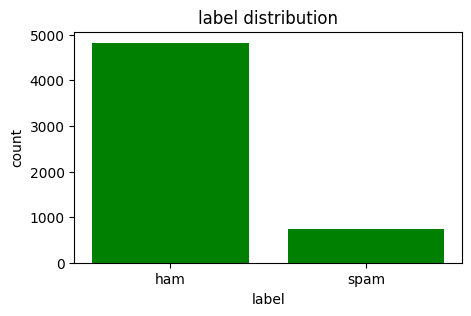

In [19]:
counts = df["label"].value_counts()

plt.figure(figsize=(5, 3))
plt.bar(counts.index, counts.values, color="green")
plt.title("label distribution")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

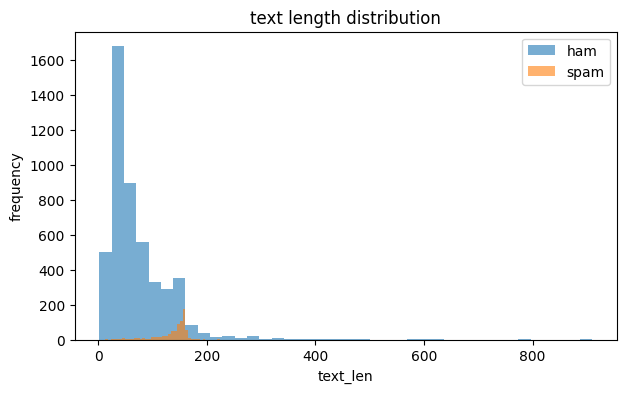

In [20]:
plt.figure(figsize=(7, 4))

for lab in ["ham", "spam"]:
    vals = df.loc[df["label"] == lab, "text_len"].values
    plt.hist(vals, bins=40, alpha=0.6, label=lab)

plt.title("text length distribution")
plt.xlabel("text_len")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [21]:
def clean_text(x: str) -> str:
    x = x.lower()
    x = re.sub(r"http\S+|www\.\S+", " ", x)              
    x = re.sub(r"\S+@\S+", " ", x)                        
    x = re.sub(r"\d+", " ", x)                            
    x = x.translate(str.maketrans("", "", string.punctuation))
    x = re.sub(r"\s+", " ", x).strip()
    return x

In [22]:
df["x"] = df["text"].apply(clean_text)

In [23]:
label2id = {"ham": 0, "spam": 1}

In [24]:
id2label = {0: "ham", 1: "spam"}

In [25]:
df["y"] = df["label"].map(label2id).astype(int)

In [26]:
df[["label", "text", "x", "y"]].head()

,label,text,x,y
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final ...,1
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,0


## 🤖 Model Training

The text data was transformed into numerical features using **TF-IDF vectorization** with unigrams and bigrams.

A **Logistic Regression** classifier was trained on these features because:
- It performs well on sparse, high-dimensional text data
- It provides interpretable coefficients for understanding important words
- It serves as a strong and efficient baseline model

Class imbalance was handled using weighted loss during training.


In [28]:
x = df["x"].values

In [29]:
y = df["y"].values

In [30]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [31]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95)

In [32]:
x_train_vec = vectorizer.fit_transform(x_train)

In [33]:
x_test_vec  = vectorizer.transform(x_test)

In [34]:
model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced")

In [35]:
model.fit(x_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000)

In [36]:
pred = model.predict(x_test_vec)

In [37]:
metrics = {
    "accuracy": float(accuracy_score(y_test, pred)),
    "precision_spam": float(precision_score(y_test, pred, pos_label=1)),
    "recall_spam": float(recall_score(y_test, pred, pos_label=1)),
    "f1_spam": float(f1_score(y_test, pred, pos_label=1)),}
metrics

{'accuracy': 0.9820627802690582,
 'precision_spam': 0.9271523178807947,
 'recall_spam': 0.9395973154362416,
 'f1_spam': 0.9333333333333333}

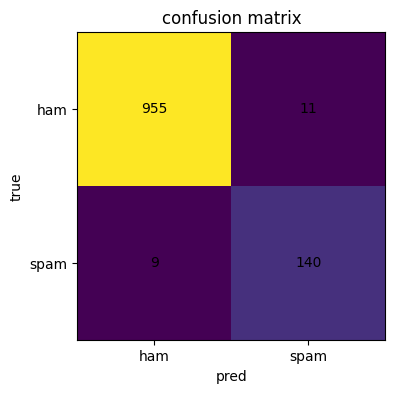

In [38]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(4, 4))
plt.imshow(cm)
plt.title("confusion matrix")
plt.xticks([0, 1], ["ham", "spam"])
plt.yticks([0, 1], ["ham", "spam"])
plt.xlabel("pred")
plt.ylabel("true")

for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")

plt.show()

## 🧠 Feature Importance Analysis

Model coefficients were analyzed to identify the most influential words for each class.

- **Spam indicators** included terms such as: *free*, *call*, *claim*, *win*, *text*
- **Ham indicators** included conversational words such as: *ok*, *sorry*, *home*, *later*, *love*

This analysis confirms that the model learned meaningful and intuitive patterns from the data.


In [39]:
feature_names = np.array(vectorizer.get_feature_names_out())
coefs = model.coef_[0]

top_n = 20

top_spam_idx = np.argsort(coefs)[-top_n:][::-1]
top_ham_idx  = np.argsort(coefs)[:top_n]

top_spam = list(zip(feature_names[top_spam_idx], coefs[top_spam_idx]))
top_ham  = list(zip(feature_names[top_ham_idx], coefs[top_ham_idx]))

In [41]:
print("top spam indicators:")
for w, c in top_spam:
    print(f"{w:25s} {c:.4f}")

top spam indicators:
call                      5.2920
txt                       5.1509
free                      4.4198
to                        3.8993
text                      3.8478
reply                     3.4227
stop                      3.4078
from                      3.2617
your                      3.2511
mobile                    3.0543
claim                     3.0377
now                       2.5619
or                        2.5437
win                       2.4581
won                       2.3147
chat                      2.3083
service                   2.2920
you have                  2.2881
prize                     2.2721
new                       2.1143


In [42]:
print("\n\ntop ham indicators:")
for w, c in top_ham:
    print(f"{w:25s} {c:.4f}")



top ham indicators:
my                        -2.6196
me                        -2.2978
ltgt                      -2.0991
ok                        -1.9230
im                        -1.8148
ill                       -1.7749
that                      -1.7541
but                       -1.6728
it                        -1.5044
come                      -1.5043
its                       -1.3718
later                     -1.3456
when                      -1.3146
home                      -1.2995
so                        -1.2809
then                      -1.2603
up                        -1.2170
got                       -1.1992
sorry                     -1.1940
at                        -1.1660


## 🖼️ WordCloud Visualization

WordCloud visualizations were created separately for ham and spam messages to provide an intuitive overview of frequently occurring words.

- Ham messages are dominated by casual, conversational terms
- Spam messages emphasize promotional and urgent language

These visualizations further support the findings from feature importance analysis.


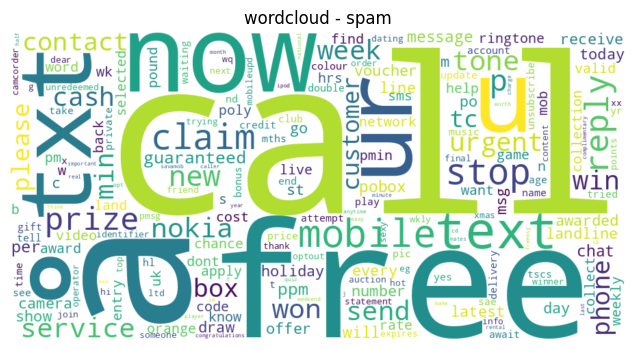

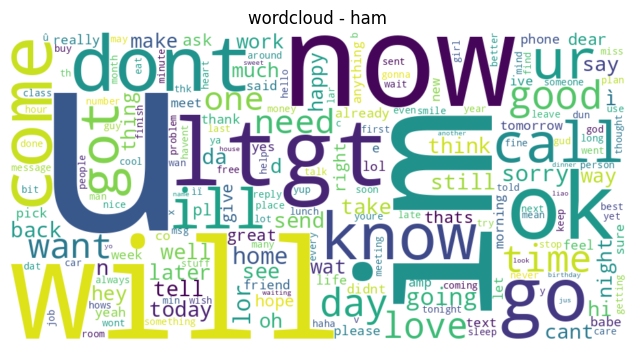

In [43]:
from wordcloud import WordCloud

def make_wordcloud(text, title):
    wc = WordCloud(
        width=900,
        height=450,
        background_color="white",
        collocations=False  
    ).generate(text)

    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

spam_text = " ".join(df.loc[df["label"] == "spam", "x"].tolist())
ham_text  = " ".join(df.loc[df["label"] == "ham",  "x"].tolist())

make_wordcloud(spam_text, "wordcloud - spam")
make_wordcloud(ham_text, "wordcloud - ham")

In [44]:
out_dir = "sms_spam_tfidf_logreg"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(model, os.path.join(out_dir, "model.joblib"))
joblib.dump(vectorizer, os.path.join(out_dir, "vectorizer.joblib"))

with open(os.path.join(out_dir, "label2id.json"), "w", encoding="utf-8") as f:
    json.dump(label2id, f, ensure_ascii=False, indent=2)

with open(os.path.join(out_dir, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

out_dir, os.listdir(out_dir)

('sms_spam_tfidf_logreg',
 ['model.joblib', 'metrics.json', 'vectorizer.joblib', 'label2id.json'])